In [16]:
base_dir = '/media/bigdata/projects/pytau'
import sys
sys.path.append(base_dir)
from pytau.changepoint_io import FitHandler, DatabaseHandler
from pytau.changepoint_analysis import PklHandler
import pylab as plt
from pytau.utils import plotting
from glob import glob
import os
import pytau.changepoint_model as models
import pylab as plt
import pymc3 as pm
import numpy as np
from scipy import stats

In [22]:
data_size = (13,100)
n_states = 4
data_array = models.gen_test_array(data_size, n_states, type = 'normal')

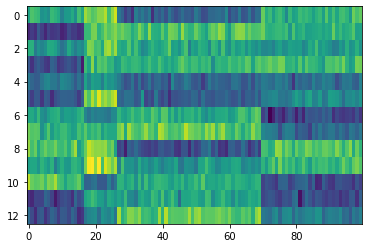

In [39]:
plt.imshow(data_array, aspect='auto');

In [25]:
# Create and fit model
n_fit = 40000
n_samples = 20000
model = models.gaussian_changepoint_2d(data_array, n_states)

with model:                                                                                                  
    inference = pm.ADVI('full-rank')                                                                         
    approx = pm.fit(n=n_fit, method=inference)                                                                 
    trace = approx.sample(draws=n_samples)
tau_samples = trace['tau']

Finished [100%]: Average Loss = -638.99


In [26]:
# Extract changepoint values
int_tau = np.vectorize(np.int)(tau_samples)
mode_tau = np.squeeze(stats.mode(int_tau, axis=0)[0])

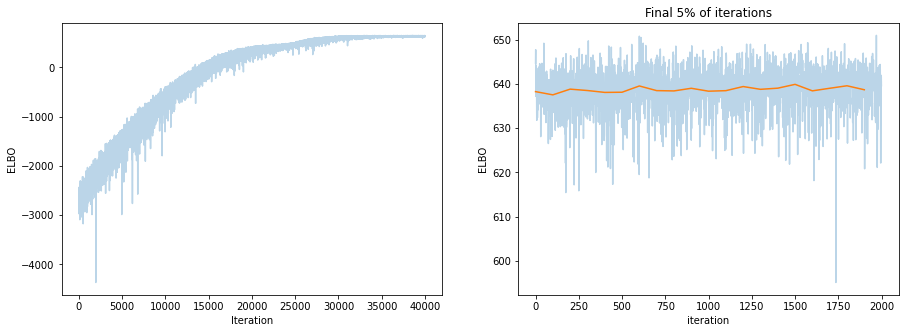

In [27]:
# Plot ELBO over iterations, should be flat by the end
fig, ax = plotting.plot_elbo_history(approx)
plt.show()

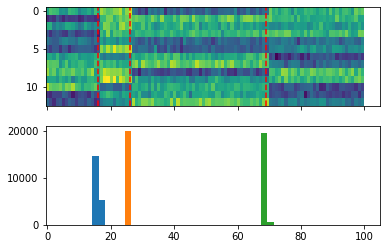

In [38]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].imshow(data_array, aspect='auto')
for val in mode_tau:
    ax[0].axvline(val, color = 'red', linestyle = '--')
for dist in int_tau.T:
    ax[1].hist(dist, bins = np.linspace(0,data_size[1],50))